<h1 style="text-align:center;">Toxic Comment Classification</h1>

### Table of Contents

1. [Step 1: Importing and Loading Data](#section-1)
2. [Step 2: Cleaning Data](#section-2)
3. [Step 3: Preprocessing Text](#section-3)
4. [Step 4: Data Visualization](#section-4)
5. [Step 5: Splitting Data](#section-5)
6. [Step 6: Text Embedding](#section-6)
7. [Step 7: Balancing Data](#section-7)
8. [Step 8: Normalizing Data](#section-8)
9. [Step 9: Model Selection](#section-9)
10. [Step 10: Model Performance](#section-10)
11. [Step 11: Threshold Tuning](#section-11)

<h2 style="text-align:center;">Step 1: Importing and Loading Data</h2> <a class="anchor" id="section-1"></a>

In [1]:
import numpy as np
import pandas as pd

import re

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from joblib import dump

from imblearn.over_sampling import SMOTE

import spacy
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
from nltk.corpus import wordnet
from gensim.models.doc2vec import Doc2Vec, TaggedDocument, Word2Vec
from gensim.test.utils import get_tmpfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, Normalizer

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the train dataset
train = pd.read_csv("train.csv")

# Let's see the data
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


We can see that there are a lot of comments where there are no labels.

<h2 style="text-align:center;">Step 2: Cleaning Data</h2> <a class="anchor" id="section-2"></a>

In [3]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult","identity_hate"]
train["no_label"] = 1 - train[label_cols].max(axis=1)
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,no_label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [4]:
# Let's check how many labels are missing
train.no_label.value_counts()

no_label
1    143346
0     16225
Name: count, dtype: int64

In [5]:
train.drop(columns=["no_label"], inplace = True)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
# Let's check the stats of the length of comments
lengths = train.comment_text.str.len()
print(f"Average Length: {lengths.mean()} \nMaximum Length: {lengths.max()} \nMinimum Length: {lengths.min()}")

Average Length: 394.0732213246768 
Maximum Length: 5000 
Minimum Length: 6


<Axes: >

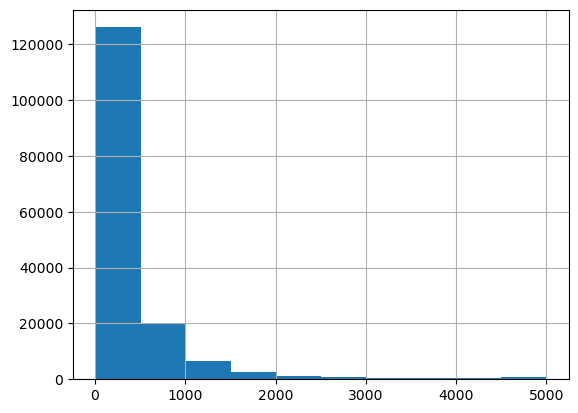

In [7]:
# Let's see how the length varies
lengths.hist()

In [8]:
print("Check for missing values in Train dataset\n",train.isnull().sum())

Check for missing values in Train dataset
 id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [9]:
# Filling the NA values with "unknown"
train["comment_text"].fillna("unknown", inplace=True)

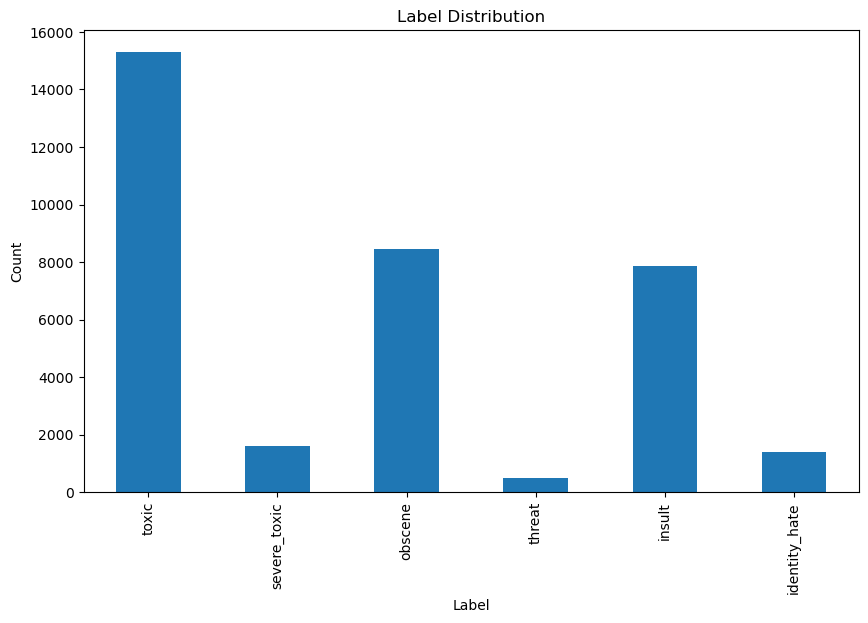

In [10]:
# Let's see the dataset
label_counts = train[label_cols].sum()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [11]:
# Function to clean the sentence.
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub("\S*#\S*\s?"," ", text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
# Let's clean the text now
train.comment_text = train.comment_text.apply(clean_text)
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
5,00025465d4725e87,congratulations from me as well use the tools ...,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [13]:
# In this project I am going to just classify whether a comment is toxic or not => Binary Classification.
train["label"] = np.where(train["toxic"]==1, 1, 
                np.where(train["severe_toxic"]==1, 1, 
                np.where(train["obscene"]==1, 1, 
                np.where(train["threat"]==1, 1,
                np.where(train["insult"]==1, 1,
                np.where(train["identity_hate"]==1, 1, 0))))))

In [14]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0
5,00025465d4725e87,congratulations from me as well use the tools ...,0,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0,1
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0,0
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0


Let's check for imbalance

In [15]:
# Count of samples for each class
Counter(train["label"])

Counter({0: 143346, 1: 16225})

In [16]:
# Ratio of Non-Toxic vs Toxic
print(Counter(train["label"])[0]/Counter(train["label"])[1])

8.834884437596301


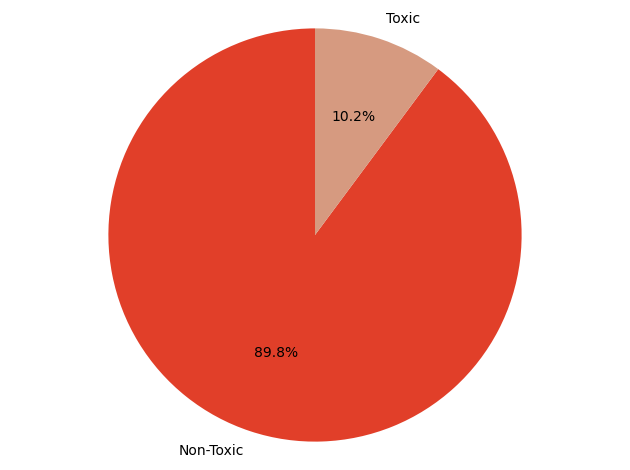

In [17]:
lbl = ['Non-Toxic', "Toxic"]
count = [Counter(train["label"])[0], Counter(train["label"])[1]]
df = pd.DataFrame({'label':lbl, 'count':count})

#pieplot
colors = ["#E13F29", "#D69A80"]

plt.pie(
    df['count'],
    labels = df['label'],
    shadow = False,
    colors = colors,
    startangle=90,
    autopct='%1.1f%%'
)
plt.axis('equal')
plt.tight_layout()
plt.show()


The ratio is almost 9:1, which means there is an imbalance in the data. Let's handle this later.

<h2 style="text-align:center;">Step 3: Preprocessing Text</h2> <a class="anchor" id="section-3"></a>

1. Remove Stop Words (articles and pronouns are identified as stop words)
2. Tokenize the text
3. Stemming the tokens (removing inflection - like "s" in dogs or "ed" in expected)

In [18]:
# Stop Words
spacy_model = spacy.load("en_core_web_sm")
stop_words = spacy_model.Defaults.stop_words
print(stop_words)

{'the', 'already', 'whether', 'they', 'does', 'among', 'both', 'on', 'above', 'are', 'its', 'seeming', 'thence', 'there', 'becomes', 'until', 'nor', 'show', 'using', 'would', 'alone', 'around', 'herein', 'see', 'however', 'i', 'for', 'her', 'between', 'last', 'take', "'ve", 'bottom', 'by', '‘s', 'yours', 'mine', 'ours', 'somehow', 'wherever', 'one', 'yourselves', 'to', 'besides', 'though', 'keep', 'who', 'although', 'might', 'thru', 'she', 'when', 'elsewhere', 'meanwhile', 'nevertheless', 'latter', "'d", 'against', 'everything', 'so', 'whereupon', 'others', 'whole', 'doing', '’ve', 'latterly', 'none', 'most', 'has', 'without', 'almost', 'either', 'those', 'get', 'nothing', 'together', 'beside', 'amongst', 'if', 'him', 'at', 'third', 'it', 'is', 'serious', 'towards', '‘ve', 'four', 'fifteen', 'could', 'in', '‘m', 'eight', '‘d', "'s", 'became', 'perhaps', 'hence', 'up', 'side', 'formerly', 'as', 'within', 'really', 'herself', 'himself', 'other', 'whatever', 'his', 'too', 'while', 'each',

In [19]:
# Tokenize our comments and remove the stop words
def tokenize(text):
    tokens = word_tokenize(str(text))
    return [word.lower() for word in tokens if word not in stop_words and not word.isdigit()]

train["tokenized_comments"] = train["comment_text"].apply(tokenize)

In [20]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label,tokenized_comments
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0,"[explanation, edits, username, hardcore, metal..."
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0,0,"[d, aww, matches, background, colour, seemingl..."
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,0,"[hey, man, trying, edit, war, guy, constantly,..."
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,0,"[real, suggestions, improvement, wondered, sec..."
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0,"[sir, hero, chance, remember, page]"


In [21]:
# Stemming
stemmer = SnowballStemmer(language="english")

def stem(tokens):
    return [stemmer.stem(token) for token in tokens]

train["stemmed_comments"] = train["tokenized_comments"].apply(stem)

In [22]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label,tokenized_comments,stemmed_comments
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0,"[explanation, edits, username, hardcore, metal...","[explan, edit, usernam, hardcor, metallica, fa..."
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0,0,"[d, aww, matches, background, colour, seemingl...","[d, aww, match, background, colour, seem, stuc..."
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,0,"[hey, man, trying, edit, war, guy, constantly,...","[hey, man, tri, edit, war, guy, constant, remo..."
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,0,"[real, suggestions, improvement, wondered, sec...","[real, suggest, improv, wonder, section, stati..."
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0,"[sir, hero, chance, remember, page]","[sir, hero, chanc, rememb, page]"


<h2 style="text-align:center;">Step 4: Data Visualization</h2> <a class="anchor" id="section-4"></a>

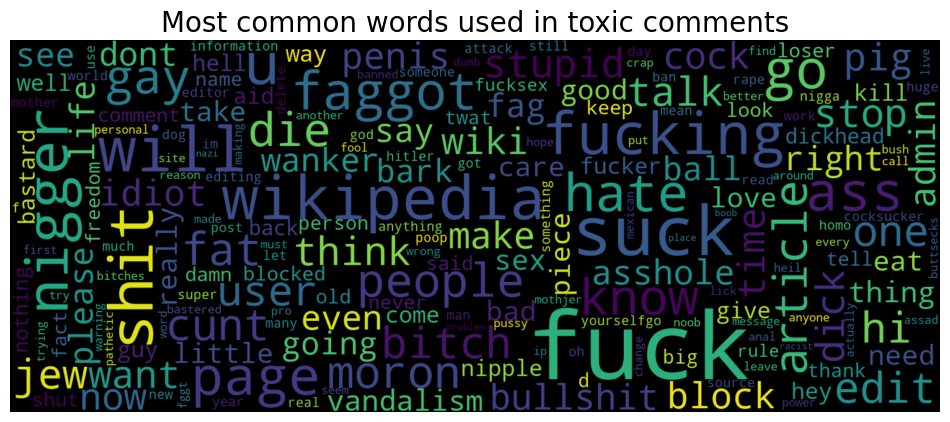

In [23]:
# Words that are common in toxic comments
toxic_series = train[train["label"] == 1]["comment_text"]
all_toxic_text = pd.Series(toxic_series).str.cat(sep=' ')

# Create and generate a word cloud image:
wordcloud = WordCloud(collocations=False, 
                            width=1500, 
                            height=600, 
                            max_font_size=150).generate(all_toxic_text)

# Display the generated image:
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Most common words used in toxic comments", size=20)
plt.show()

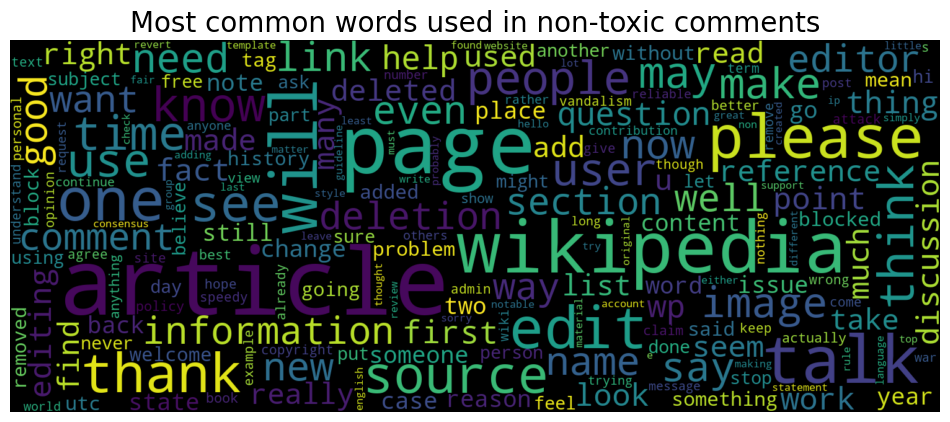

In [24]:
# Words that are common in non-toxic comments
non_toxic_series = train[train["label"] == 0]["comment_text"]
all_non_toxic_text = pd.Series(non_toxic_series).str.cat(sep=' ')

# Create and generate a word cloud image:
wordcloud = WordCloud(collocations=False, 
                            width=1500, 
                            height=600, 
                            max_font_size=150).generate(all_non_toxic_text)

# Display the generated image:
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Most common words used in non-toxic comments", size=20)
plt.show()

<h2 style="text-align:center;">Step 5: Splitting Data</h2> <a class="anchor" id="section-5"></a>

In [25]:
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(train["stemmed_comments"], train["label"], random_state=42)

<h2 style="text-align:center;">Step 6: Text Embedding</h2> <a class="anchor" id="section-6"></a>

I am trying three embeddings here: TF-IDF, Word2Vec, Doc2Vec.

### TF-IDF

In [26]:
# Avoiding Tokenizing
def do_nothing(lemmas):
    return lemmas

# Text to Vector Encoding
tfid = TfidfVectorizer(lowercase=False, tokenizer=do_nothing, max_features=500)

train_vectors_tfidf = tfid.fit_transform(X_train).toarray()
test_vectors_tfidf = tfid.transform(X_test).toarray()

### Word2Vec

In [27]:
# Word2Vec model
w2v = Word2Vec(
                sg=0,                   # 0 for CBOW
                vector_size=500,        
                workers=10, 
                epochs=100,             
                seed=42                 
            )            

# Train Word2Vec
w2v.build_vocab(X_train, progress_per=50000)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=30, report_delay=1)

# Saving the Model to avoid training again
w2v.save("w2vec.model")
print("Model Saved")

Model Saved


In [28]:
wordVec = Word2Vec.load("./w2vec.model").wv
print("Model Loaded")

Model Loaded


In [29]:
# Average of Each word in the comment that make the comment.
def embedding_feats(corpus, w2v_model):
    DIMENSION = 500
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in corpus:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats


train_vectors_w2v = embedding_feats(X_train, wordVec)
test_vectors_w2v = embedding_feats(X_test, wordVec)

### Doc2Vec

In [30]:
# Doc2Vec Model
train_doc2vec = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(X_train)]

#Train Doc2Vec
model = Doc2Vec(
                vector_size=500,                
                dm=0,                           # 0 for DBOW
                epochs=100,                     
                seed=42,                        
                workers=10,         
                )        

# Train Doc2Vec
model.build_vocab(train_doc2vec)
model.train(train_doc2vec, total_examples=model.corpus_count, epochs=model.epochs)

# Saving the Model to avoid training again
model.save("d2vec.model")
print("Model Saved")

Model Saved


In [31]:
model_d2v= Doc2Vec.load("d2vec.model")
print("Model Loaded")

Model Loaded


In [32]:
# Doc2Vec Embedding
train_vectors_d2v =  [model_d2v.infer_vector(tokens, epochs=70) for tokens in X_train]
test_vectors_d2v = [model_d2v.infer_vector(tokens, epochs=70) for tokens in X_test]

<h2 style="text-align:center;">Step 7: Balancing Data</h2> <a class="anchor" id="section-7"></a>

In [33]:
# Ratio of Non-Toxic vs Toxic
print(Counter(train["label"])[0]/Counter(train["label"])[1])

8.834884437596301


Using SMOTE to balance the data.

In [34]:
# SMOTE for the TF-IDF
sm_tfidf = SMOTE(random_state=42, n_jobs=10)
train_vectors_tfidf, y_train_tfidf = sm_tfidf.fit_resample(train_vectors_tfidf, y_train)
test_vectors_tfidf, y_test_tfidf = sm_tfidf.fit_resample(test_vectors_tfidf, y_test)

In [35]:
# SMOTE for the Word2Vec
sm_w2v = SMOTE(random_state=42, n_jobs=10)
train_vectors_w2v, y_train_w2v = sm_w2v.fit_resample(train_vectors_w2v, y_train)
test_vectors_w2v, y_test_w2v = sm_w2v.fit_resample(test_vectors_w2v, y_test)

In [36]:
# SMOTE for the Doc2Vec
sm_d2v = SMOTE(random_state=42, n_jobs=10)
train_vectors_d2v, y_train_d2v = sm_d2v.fit_resample(train_vectors_d2v, y_train)
test_vectors_d2v, y_test_d2v = sm_d2v.fit_resample(test_vectors_d2v, y_test)

<h2 style="text-align:center;">Step 8: Normalizing Data</h2> <a class="anchor" id="section-8"></a>

In [37]:
# TF-IDF Normalization
norm_TFIDF = Normalizer(copy=False)
norm_train_tfidf = norm_TFIDF.fit_transform(train_vectors_tfidf)
norm_test_tfidf = norm_TFIDF.transform(test_vectors_tfidf)

In [38]:
# Word2Vec Normalization
norm_W2V = Normalizer(copy=False)
norm_train_w2v = norm_W2V.fit_transform(train_vectors_w2v)
norm_test_w2v = norm_W2V.transform(test_vectors_w2v)

In [39]:
# Doc2Vec Normalizations
norm_D2V = Normalizer(copy=False)
norm_train_d2v = norm_D2V.fit_transform(train_vectors_d2v)
norm_test_d2v = norm_D2V.transform(test_vectors_d2v)

<h2 style="text-align:center;">Step 9: Model Selection</h2> <a class="anchor" id="section-9"></a>

Models I am going to try for this classification problem:

    1.	Linear SVC
    2.	Logistic Regression
    3.	K-nearest Neighbors
    4.	Decision Tree Classifier
    5.	Random Forest
    6.	Naïve Bayes

In [40]:
# Function for the three models
num_neighbours = 3
def create_models(seed=42, classW="balanced"):
    models = []
    # we can append more than one model to test
    models.append(('Linear SVC', LinearSVC(random_state=seed, class_weight=classW)))
    models.append((f'K-Nearest Neighbours({num_neighbours})', KNeighborsClassifier(n_neighbors=num_neighbours)))
    models.append(('Logistic Regression', LogisticRegression(random_state=seed, class_weight=classW, n_jobs=10, max_iter=300)))
    models.append(('Naive Bayes', MultinomialNB()))
    models.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)))
    models.append(('Random Forest Classifier', RandomForestClassifier(n_estimators=105, min_samples_split=2, random_state=42)))
    return models

In [41]:
# Lets call create_models to create the three models
models = create_models()

In [42]:
# This function returns a dataframe which has all the evaluation metrics.
def model_evaluation(y_test, predictions, modelName):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    prec=precision_score(y_test, predictions)
    rec=recall_score(y_test, predictions)
    f1=f1_score(y_test, predictions)
    acc=accuracy_score(y_test, predictions)
    # specificity
    spec=tn/(tn+fp)

    score = {'Model': [modelName], 'Accuracy': [acc], 'f1': [f1], 'Recall': [rec], 'Precision': [prec], \
        'Specificity': [spec], 'TP': [tp], 'TN': [tn], 'FP': [fp], 'FN': [fn], 'y_test size': [len(y_test)]}
    df_score = pd.DataFrame(data=score)
    return df_score

In [43]:
# Function to test this models end-to-end
def test_models(models, X_train, y_train, X_test, y_test):
    score = pd.DataFrame()
    for name, model in models:
        # We have to scale the values in case of Naive Bayes Algorithm
        if name=="Naive Bayes":
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        # Fit the model
        model.fit(X_train, y_train)
        # Predictions with the testing data
        preds = model.predict(X_test)
        tmp = model_evaluation(y_test, preds, name)
        score = pd.concat([score, tmp])
    return score

### TF-IDF

In [44]:
# For TF-IDF
test_models(models, norm_train_tfidf, y_train_tfidf, norm_test_tfidf, y_test_tfidf)

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,Linear SVC,0.828306,0.823587,0.801557,0.846861,0.855054,28723,30640,5194,7111,71668
0,K-Nearest Neighbours(3),0.737861,0.699182,0.609282,0.820204,0.866440,21833,31048,4786,14001,71668
0,Logistic Regression,0.828040,0.823746,0.803678,0.844843,0.852403,28799,30545,5289,7035,71668
0,Naive Bayes,0.811743,0.795978,0.734470,0.868729,0.889016,26319,31857,3977,9515,71668
0,Decision Tree Classifier,0.794874,0.770006,0.686750,0.876233,0.902997,24609,32358,3476,11225,71668
0,Random Forest Classifier,0.816948,0.791864,0.696434,0.917601,0.937462,24956,33593,2241,10878,71668


### Word2Vec

In [45]:
test_models(models, norm_train_w2v, y_train_w2v, norm_test_w2v, y_test_w2v)

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,Linear SVC,0.923383,0.922172,0.907825,0.936980,0.938941,32531,33646,2188,3303,71668
0,K-Nearest Neighbours(3),0.856226,0.857463,0.864905,0.850148,0.847547,30993,30371,5463,4841,71668
0,Logistic Regression,0.923160,0.921970,0.907909,0.936473,0.938410,32534,33627,2207,3300,71668
0,Naive Bayes,0.842035,0.834843,0.798487,0.874668,0.885584,28613,31734,4100,7221,71668
0,Decision Tree Classifier,0.825961,0.812984,0.756572,0.878487,0.895351,27111,32084,3750,8723,71668
0,Random Forest Classifier,0.876346,0.864408,0.788302,0.956781,0.964391,28248,34558,1276,7586,71668


### Doc2Vec

In [46]:
test_models(models, norm_train_d2v, y_train_d2v, norm_test_d2v, y_test_d2v)

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,Linear SVC,0.923885,0.922792,0.909723,0.936242,0.938048,32599,33614,2220,3235,71668
0,K-Nearest Neighbours(3),0.877658,0.880411,0.900681,0.861034,0.854635,32275,30625,5209,3559,71668
0,Logistic Regression,0.923997,0.922931,0.910169,0.936056,0.937824,32615,33606,2228,3219,71668
0,Naive Bayes,0.884900,0.879130,0.837166,0.925524,0.932634,29999,33420,2414,5835,71668
0,Decision Tree Classifier,0.802073,0.785489,0.724759,0.857327,0.879388,25971,31512,4322,9863,71668
0,Random Forest Classifier,0.852459,0.830425,0.722526,0.976208,0.982391,25891,35203,631,9943,71668


It is recommended to use num_neighbours as odd to avoid ties when determining the majority class among the neighbors.

We can see that Logistic Regression with Doc2Vec Embedding seems to do better. Let's use RandomizedSearch to find the best parameters to see if we can improve the performance a little better. I am not using GridSearch here because it is computationally expensive and takes too long. 

So, by using RandomizedSearch, we are not sure if we found the best parameters.

In [47]:
# # Logistic Regression Parameters
# logit_param = {"penalty" : ["l1","l2"],
#                 "tol" : [0.004, 0.04, 0.4],
#                 "C" : [0.5, 1, 1.5, 2],
#                 "random_state" : [42],
#                 "solver" : ["liblinear", "newton-cg"],
#                 "max_iter" : [200,400]
#             }

# # Lets run the search and fit our model
# final_model = RandomizedSearchCV(LogisticRegression(), 
#                                 logit_param, 
#                                 random_state=42, 
#                                 cv=8, 
#                                 verbose=-1, 
#                                 n_jobs=10, 
#                                 n_iter=8)
                                
# final_model.fit(norm_train_d2v, y_train_d2v)

In [48]:
final_model = LogisticRegression(random_state=42, class_weight="balanced", n_jobs=10, max_iter=300)
final_model.fit(norm_train_d2v, y_train_d2v)

LogisticRegression(class_weight='balanced', max_iter=300, n_jobs=10,
                   random_state=42)

In [49]:
# Let's predict on test data
preds = final_model.predict(norm_test_d2v)

In [50]:
# Let's do our model evaluation
model_evaluation(y_test_d2v, preds, "Logistic Regression D2V")

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,Logistic Regression D2V,0.923997,0.922931,0.910169,0.936056,0.937824,32615,33606,2228,3219,71668


In [51]:
# Lets get the probability of each predicted value
probability = final_model.predict_proba(norm_test_d2v)

Storing this model to avoid retraining

In [52]:
dump(final_model, 'toxicCommModel.joblib')

['toxicCommModel.joblib']

<h2 style="text-align:center;">Step 10: Model Evaluation</h2> <a class="anchor" id="section-10"></a>

I am setting a threshold for probability of belonging to a class

In [53]:
# Based on a custom threshold, it will display which class it belongs to. 
def prediction_probability(prob, threshold):
    pred=[]
    for x in prob[:,1]:
        if x>threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred

In [54]:
# Let's do our model evaluation
predictions=prediction_probability(probability, 0.5)
model_evaluation(y_test_d2v, predictions, "Logistic Regression, t=0.5")

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,"Logistic Regression, t=0.5",0.923997,0.922931,0.910169,0.936056,0.937824,32615,33606,2228,3219,71668


We have some False Positives and False Negatives: this leads us to a more advanced threshold tuning in order to decide, based on the application, which is the important metric to maximize (precision or recall based on the cost of a FN and the cost of a FP)

## ROC AUC, Precision-Recall Curve

Before tuning the threshold, lets do some plots which will help to decide the "trade off" between all the metrics. The threshold choice starts from this trade off.

In [55]:
# calculate ROC AUC Score
print("SVM: ROC AUC = %.4f" % roc_auc_score(y_test_d2v, probability[:, 1]))

SVM: ROC AUC = 0.9773


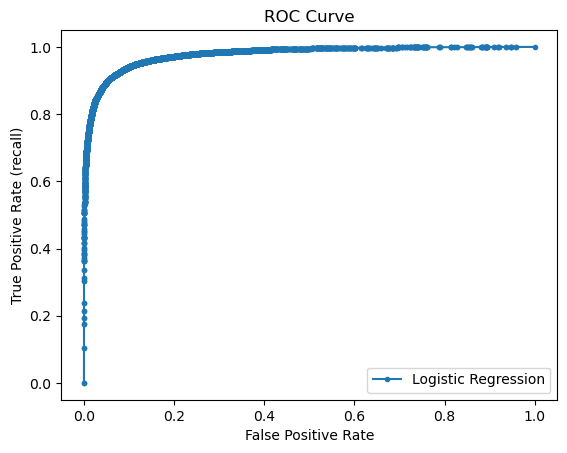

In [56]:
# ROC Curve
model_fpr, model_tpr, _ = roc_curve(y_test_d2v, probability[:, 1])

plt.plot(model_fpr, model_tpr, marker='.', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.legend()
plt.title("ROC Curve")
plt.show()

## Precision Recall Curve

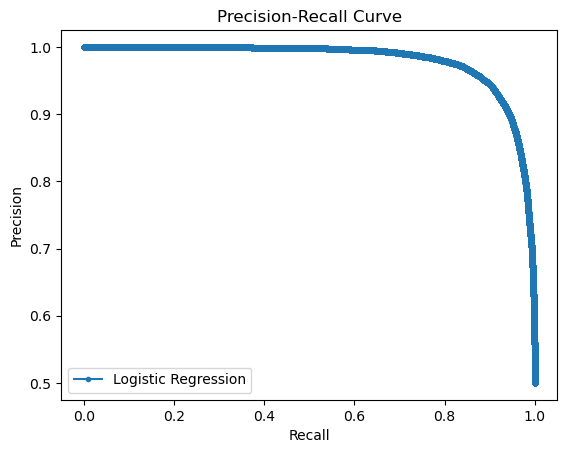

In [57]:
# calculate precision-recall curve
model_precision, model_recall, thresholds = precision_recall_curve(y_test_d2v, probability[:, 1])
# plot the curve
plt.plot(model_recall, model_precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

We can now start the threshold tuning. We can choose a value of threshold that matches the desired values of precision and recall.

<h2 style="text-align:center;">Step 11: Threshold Tuning</h2> <a class="anchor" id="section-11"></a>

In classifying toxic comments, we can decide which metric to maximise based on the cost of a false positive or false negative, there is no right or wrong answer here.

Let's try to maximize precision that means cost of FP > cost of FN. Let's tune the threshold until we are satisfied with the number of FP and FN

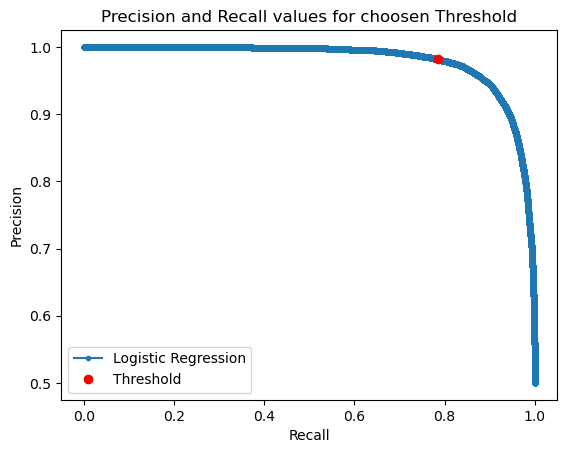

In [58]:
# plotting precision-recall curve with the choosen threshold
plt.plot(model_recall, model_precision, marker='.', label='Logistic Regression')
plt.plot(model_recall[43000], model_precision[43000], "ro", label="Threshold")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision and Recall values for choosen Threshold')
plt.show()

In [59]:
# Let's see the threshold value chosen
print("Threshold value = %.4f" % thresholds[43000])

Threshold value = 0.8717


In [60]:
# Let's do our model evaluation
model_evaluation(y_test_d2v, preds, "Logistic Regression, D2V")

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,"Logistic Regression, D2V",0.923997,0.922931,0.910169,0.936056,0.937824,32615,33606,2228,3219,71668


In [61]:
# Let's do our model evaluation
predictions=prediction_probability(probability, 0.5)
model_evaluation(y_test_d2v, predictions, "Logistic Regression, t=0.5")

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,"Logistic Regression, t=0.5",0.923997,0.922931,0.910169,0.936056,0.937824,32615,33606,2228,3219,71668


Let's now see the FP with this threshold value

In [63]:
# For the final threshold 0.8717
predictions=prediction_probability(probability, thresholds[43000])
model_evaluation(y_test_d2v, predictions, "Logistic Regression, custom threshold")

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,"Logistic Regression, custom threshold",0.885151,0.87239,0.785148,0.981442,0.985154,28135,35302,532,7699,71668


We can see that the false positives have dropped to 532, precision has increased to 0.98.